This notebook trains a CBOW model using keras instead of using gensim

In [10]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Embedding, Lambda, Dense
import keras.backend as K


<b> Load Data </b>  
* Data has been preprocessed in the "ingredients_recommendation.ipynb" notebook

In [3]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]

<b> Prepare data </b>  
* Tokenize 
* Generate (context_words, target) pairs  
* Prepare data in numpy array format X, y  
* Split train and test set

In [4]:
# tokenize 
t=Tokenizer()  
t.fit_on_texts(ingredients)
encoded_recipes=t.texts_to_sequences(ingredients)

# create reverse dictionary from index to words 
index_to_words=dict(map(reversed,t.word_index.items())) 

# number of words
n_words = len(t.word_index)
print('number of words: ', n_words)

number of words:  6713


<b> Generate (context, target) pairs </b>
* target: integer representing the target word
* context: list of integers corresponding to the context of target word  
* In recipe data, context words are going to be a list of randomly sampled ingredients that belong in the same recipe  
* If a recipe involves less than "context_size" number of ingredients, we'll pad the context list with 0s

In [5]:
context_size = 5

n_recipes = len(encoded_recipes)
context = []
target = []

for i in range(n_recipes):
    recipe = encoded_recipes[i]
    for j in range(len(recipe)):
        # add word to target
        target_word = recipe[j]
        target.append(target_word)
        
        # add context 
        ings = recipe.copy()
        ings.remove(target_word)
        ings = [item-1 for item in ings]
        
        if len(ings) <= context_size:
            context.append(ings)
        else:
            # find a random subset of size "context_size"
            context_sub = random.sample(ings, context_size)
            context.append(context_sub)
    
# pad 0's so that every context has lenth "context_size" 
X = pad_sequences(context, maxlen = context_size, padding = 'post')

# create array y
y = np.zeros((len(target), n_words))
for idx, item in enumerate(target):
    # convert to one-hot vector 
    y[idx, item-1] = 1
    
# split to training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

<b> Create model </b>  
* Implement the CBOW model, as described in the paper <a href="https://arxiv.org/pdf/1301.3781.pdf">"Efficient Estimation of Word Representations in Vector Space" </a>  
* Note: we are not implementing any negative sampling or hierarchical softmax, so training can be slow.
![](files/images/CBOW.png)  


In [6]:
embed_size = 100

model = Sequential()

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size ))
# Take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,) ))
# last layer
model.add(Dense(n_words, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 5, 100)            671300    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6713)              678013    
Total params: 1,349,313
Trainable params: 1,349,313
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fit
history = model.fit(x = X_train, y = y_train, validation_split = 0.2, epochs = 5)

C:\Users\irish\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 262107 samples, validate on 65527 samples
Epoch 1/5
262107/262107 [==============================] - 226s 861us/step - loss: 6.2595 - accuracy: 0.0514 - val_loss: 5.8984 - val_accuracy: 0.0720
Epoch 2/5
262107/262107 [==============================] - 226s 861us/step - loss: 5.7066 - accuracy: 0.0804 - val_loss: 5.7044 - val_accuracy: 0.0835
Epoch 3/5
262107/262107 [==============================] - 224s 856us/step - loss: 5.5050 - accuracy: 0.0904 - val_loss: 5.6257 - val_accuracy: 0.0845
Epoch 4/5
262107/262107 [==============================] - 226s 863us/step - loss: 5.3673 - accuracy: 0.0974 - val_loss: 5.5838 - val_accuracy: 0.0863
Epoch 5/5
262107/262107 [==============================] - 226s 863us/step - loss: 5.2553 - accuracy: 0.1023 - val_loss: 5.5661 - val_accuracy: 0.0852


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


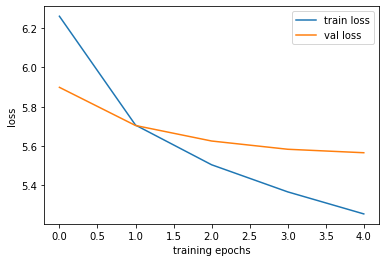

In [11]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 
print(history.history.keys())
train_loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = len(train_loss)

plt.plot(list(range(n_epochs)), train_loss, label ='train loss')
plt.plot(list(range(n_epochs)), val_loss, label ='val loss')
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

<b> Making predictions using the trained model </b>

In [13]:
given_ing = ['korean', 'chicken']
X_new = [[t.word_index[item] for item in given_ing]]

# pad context to have length "context_size"
X_new = pad_sequences(X_new, maxlen = context_size, padding = 'post')

In [17]:
# get predictions 
prob = model.predict_proba(X_new)

# print top 10 predictions starting with the most probable one
idx = prob.argsort()[0,:][::-1][:10]
for item in idx:
    print(index_to_words[item+1], prob[0,item])

sugar 0.068955615
pepper 0.064085275
water 0.05886516
vegetable_oil 0.04391799
ground_black_pepper 0.026043985
garlic 0.02239496
onions 0.017007584
olive_oil 0.016360262
garlic_cloves 0.015633933
chopped_cilantro_fresh 0.014442924
